# 弱教師あり学習をやってみよう

## 弱教師あり学習のおさらい

## 弱教師あり学習による肺セグメンテーション

### 問題設定
~の論文を参考に，弱教師ありセグメンテーションに挑戦しましょう．\
ここでの「弱教師」は，アノテーションを省エネで付与した場合を考えます．\
具体的には，肺領域をかなり雑に塗ったようなラベルが得られているとします（図１）．

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import glob

class ChestDataset(Dataset):
    def __init__(self, TrainValTest="train", shuffle=True):
        super().__init__()
        
        if TrainValTest == "train":
            self.img_path_list = sorted(glob.glob("/takaya_workspace/self_study/deep_learning/segmentation/data/train/org/*"))
            self.label_path_list = sorted(glob.glob("/takaya_workspace/self_study/deep_learning/segmentation/data/train/weak_label/*"))
        elif TrainValTest == "val":
            self.img_path_list = sorted(glob.glob("/takaya_workspace/self_study/deep_learning/segmentation/data/val/org/*"))
            self.label_path_list = sorted(glob.glob("/takaya_workspace/self_study/deep_learning/segmentation/data/val/label/*"))
        elif TrainValTest == "test":
            self.img_path_list = sorted(glob.glob("/takaya_workspace/self_study/deep_learning/segmentation/data/test/org/*"))
            self.label_path_list = sorted(glob.glob("/takaya_workspace/self_study/deep_learning/segmentation/data/test/label/*"))
            
    
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        image_path = self.img_path_list[index]
        label_path = self.label_path_list[index]
        img = np.array(Image.open(image_path))
        img = self.add_axis(img)
        label = np.array(Image.open(label_path))
        label = self._label_transform(label)
        label = self.add_axis(label)
        return img, label
    
    def _label_transform(self, label):# transformの関数に書き換える
        nonzero = np.nonzero(label)
        label[nonzero] = 1
        return label
    
    def add_axis(self, arr):# transformの関数に書き換える
        arr_new = np.expand_dims(arr, 0)
        return arr_new

In [13]:
chest_train = ChestDataset(TrainValTest="train", shuffle=True)
chest_val = ChestDataset(TrainValTest="val", shuffle=False)
chest_test = ChestDataset(TrainValTest="test", shuffle=False)
train_loader = DataLoader(chest_train, batch_size=5, shuffle=True)
val_loader = DataLoader(chest_val, batch_size=5, shuffle=False)
test_loader = DataLoader(chest_test, batch_size=5, shuffle=False)

In [14]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
class UNet(nn.Module):

    def __init__(self, n_class=2, input_channel=1, output_channel=1):
        super(UNet, self).__init__()
        self.n_class = n_class
        
        self.input_channel = input_channel
        self.output_channel = output_channel
        
        self.enco1_1 = nn.Conv2d(self.input_channel, 64, kernel_size=3, stride=1, padding=1)
        self.enco1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.enco2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.enco2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.enco3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.enco3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.enco4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.enco4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.enco5_1 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.enco5_2 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)

        self.deco6_1 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.deco6_2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)

        self.deco7_1 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.deco7_2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)

        self.deco8_1 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deco8_2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)

        self.deco9_1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deco9_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.final_layer = nn.Conv2d(64, self.output_channel, kernel_size=1)

        self.bn1_1 = nn.BatchNorm2d(  64)
        self.bn1_2 = nn.BatchNorm2d(  64)

        self.bn2_1 = nn.BatchNorm2d(  128)
        self.bn2_2 = nn.BatchNorm2d(  128)

        self.bn3_1 = nn.BatchNorm2d(  256)
        self.bn3_2 = nn.BatchNorm2d(  256)

        self.bn4_1 = nn.BatchNorm2d(  512)
        self.bn4_2 = nn.BatchNorm2d(  512)

        self.bn5_1 = nn.BatchNorm2d(  1024)
        self.bn5_2 = nn.BatchNorm2d(  512)

        self.bn6_1 = nn.BatchNorm2d(  512)
        self.bn6_2 = nn.BatchNorm2d(  256)

        self.bn7_1 = nn.BatchNorm2d(  256)
        self.bn7_2 = nn.BatchNorm2d(  128)

        self.bn8_1 = nn.BatchNorm2d(  128)
        self.bn8_2 = nn.BatchNorm2d(  64)

        self.bn9_1 = nn.BatchNorm2d(  64)
        self.bn9_2 = nn.BatchNorm2d(  64)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  

    def forward(self, x): #x = (batchsize, 3, 360, 480)
        #if LRN:
        #    x = F.local_response_normalization(x) #Needed for preventing from overfitting

        h1_1 = F.relu(self.bn1_1(self.enco1_1(x)))
        h1_2 = F.relu(self.bn1_2(self.enco1_2(h1_1)))
        pool1, pool1_indice = F.max_pool2d(h1_2, 2, stride=2, return_indices=True) #(batchsize,  64, 180, 240)

        h2_1 = F.relu(self.bn2_1(self.enco2_1(pool1)))
        h2_2 = F.relu(self.bn2_2(self.enco2_2(h2_1)))
        pool2, pool2_indice = F.max_pool2d(h2_2, 2, stride=2, return_indices=True) #(batchsize, 128,  90, 120) 

        h3_1 = F.relu(self.bn3_1(self.enco3_1(pool2)))
        h3_2 = F.relu(self.bn3_2(self.enco3_2(h3_1)))
        pool3, pool3_indice = F.max_pool2d(h3_2, 2, stride=2, return_indices=True) #(batchsize, 256,  45,  60) 

        h4_1 = F.relu(self.bn4_1(self.enco4_1(pool3)))
        h4_2 = F.relu(self.bn4_2(self.enco4_2(h4_1)))
        pool4, pool4_indice = F.max_pool2d(h4_2, 2, stride=2, return_indices=True) #(batchsize, 256,  23,  30) 

        h5_1 = F.relu(self.bn5_1(self.enco5_1(pool4)))
        h5_2 = F.relu(self.bn5_2(self.enco5_2(h5_1)))
        
        up5 = F.max_unpool2d(h5_2, pool4_indice, kernel_size=2, stride=2, output_size=(pool3.shape[2], pool3.shape[3]))
        h6_1 = F.relu(self.bn6_1(self.deco6_1(torch.cat((up5, h4_2), dim=1))))
        h6_2 = F.relu(self.bn6_2(self.deco6_2(h6_1)))

        up6 = F.max_unpool2d(h6_2, pool3_indice, kernel_size=2, stride=2, output_size=(pool2.shape[2], pool2.shape[3]))
        h7_1 = F.relu(self.bn7_1(self.deco7_1(torch.cat((up6, h3_2), dim=1))))
        h7_2 = F.relu(self.bn7_2(self.deco7_2(h7_1)))

        up7 = F.max_unpool2d(h7_2, pool2_indice, kernel_size=2, stride=2, output_size=(pool1.shape[2], pool1.shape[3]))
        h8_1 = F.relu(self.bn8_1(self.deco8_1(torch.cat((up7, h2_2), dim=1))))
        h8_2 = F.relu(self.bn8_2(self.deco8_2(h8_1)))

        up8 = F.max_unpool2d(h8_2, pool1_indice, kernel_size=2, stride=2, output_size=(x.shape[2], x.shape[3])) #x = (batchsize, 128, 360, 480)
        h9_1 = F.relu(self.bn9_1(self.deco9_1(torch.cat((up8, h1_2), dim=1))))
        h9_2 = F.relu(self.bn9_2(self.deco9_2(h9_1)))

        h = self.final_layer(h9_2)
        #print(h.shape)
        #print(t.shape)
        predict = h
        #loss = 	nn.BCEWithLogitsLoss(h, t)
        
        #predict = nn.Softmax(h)
        return torch.sigmoid(predict)

In [15]:
from torch.autograd import Function
from torch import einsum


class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)


class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

class NaiveSizeLoss(nn.Module):
    """
    This one implement the naive quadratic penalty
    penalty = 0                  if a <= pred_size
              (a - pred_size)^2  otherwise
    """
    def __init__(self):
        super(NaiveSizeLoss, self).__init__()

    def __call__(self, pred_softmax, bounds):
        #assert simplex(pred_softmax)

        B, K, H, W = pred_softmax.shape
        #assert bounds.shape == (B, K, 2)

        pred_size = einsum("bkwh->bk", pred_softmax)
        #print(pred_size)
        upper_bounds = bounds[1]
        lower_bounds = bounds[0]
        assert (upper_bounds >= 0).all() and (lower_bounds >= 0).all()

        # size < upper <==> size - upper < 0
        # lower < size <==> lower - size < 0
        
        loss = F.relu(pred_size - upper_bounds) ** 2 + F.relu(lower_bounds - pred_size) ** 2
        loss /= (W * H)

        return loss.sum() / 100

In [26]:
import torch.optim as optim

# モデルの定義
model = UNet()
model = model.to("cuda")

# optimizerの準備
optimizer = optim.RAdam(model.parameters())

# 誤差関数の定義
#criterion = BCEDiceLoss()
bce = nn.BCELoss()
sl = NaiveSizeLoss()

# 訓練ループ

batchsize = 5

train_size = len(chest_train)
val_size = len(chest_val)

epochs = 300

train_loss_list = [] # epoch毎のtrain_lossを保存しておくための入れ物
val_loss_list = [] # epoch毎のvalidation_lossを保存しておくための入れ物

loss_min = 100000

#bounds = torch.Tensor([13175.0, 29502.0])
bounds = torch.Tensor([25000.0, 29502.0])

for epoch in range(epochs):
    train_loss_add = 0 # 1エポック分の誤差を累積しておくための変数
    model.train() #学習モードであることを明示
    for i, data in enumerate(train_loader):
        x, t = data
        x = torch.tensor(x) / 255
        t = torch.tensor(t).float()
        
        x = x.to("cuda")
        t = t.to("cuda")
        
        predict = model(x)
        
        bce_loss = bce(predict, t)
        sl_loss = sl(predict, bounds)
        loss = bce_loss + sl_loss
        #loss = bce_loss
        model.zero_grad()
        loss.backward() # 誤差逆伝播法により，各パラメータについての勾配を求める
        optimizer.step() # 上で求めた勾配を用いて，山が低くなっている方へ一歩進む
        
        train_loss_add += loss.data
        
    train_loss_mean = train_loss_add / int(train_size/batchsize)
    print("epoch" + str(epoch+1))
    #print(bce_loss, sl_loss)
    print("train_loss:" + str(train_loss_mean))
    train_loss_list.append(train_loss_mean.cpu())
    
    # validation
    model.eval()
    val_loss_add = 0
    num = 0
    for i, data in enumerate(val_loader):
            
        #cudaに変換
        x, t = data
        x = torch.tensor(x) / 255
        t = torch.tensor(t).float()
        x = x.to("cuda")
        t = t.to("cuda")
        predict = model(x)
        
        loss = bce(predict, t)
        val_loss_add += loss.data
        
    val_loss_mean = val_loss_add / int(val_size/batchsize)
    print("val_loss:" + str(val_loss_mean))
    val_loss_list.append(val_loss_mean.cpu())
    
    if val_loss_mean < loss_min:
        torch.save(model.state_dict(), "/takaya_workspace/self_study/deep_learning/segmentation/models/best.model")
        print("saved best model!")
        loss_min = val_loss_mean

/tmp/ipykernel_8127/1597229496.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x) / 255
/tmp/ipykernel_8127/1597229496.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).float()


epoch1
train_loss:tensor(0.5734, device='cuda:0')
val_loss:tensor(0.6603, device='cuda:0')


/tmp/ipykernel_8127/1597229496.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x) / 255
/tmp/ipykernel_8127/1597229496.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).float()


saved best model!
epoch2
train_loss:tensor(0.5253, device='cuda:0')
val_loss:tensor(0.6478, device='cuda:0')
saved best model!
epoch3
train_loss:tensor(0.5113, device='cuda:0')
val_loss:tensor(0.6219, device='cuda:0')
saved best model!
epoch4
train_loss:tensor(0.4884, device='cuda:0')
val_loss:tensor(0.5988, device='cuda:0')
saved best model!
epoch5
train_loss:tensor(0.4712, device='cuda:0')
val_loss:tensor(0.5894, device='cuda:0')
saved best model!
epoch6
train_loss:tensor(0.4832, device='cuda:0')
val_loss:tensor(0.6042, device='cuda:0')
epoch7
train_loss:tensor(0.4765, device='cuda:0')
val_loss:tensor(0.5379, device='cuda:0')
saved best model!
epoch8
train_loss:tensor(0.5070, device='cuda:0')
val_loss:tensor(0.5927, device='cuda:0')
epoch9
train_loss:tensor(0.4957, device='cuda:0')
val_loss:tensor(0.6356, device='cuda:0')
epoch10
train_loss:tensor(0.5539, device='cuda:0')
val_loss:tensor(0.6351, device='cuda:0')
epoch11
train_loss:tensor(0.5438, device='cuda:0')
val_loss:tensor(0.646

KeyboardInterrupt: 

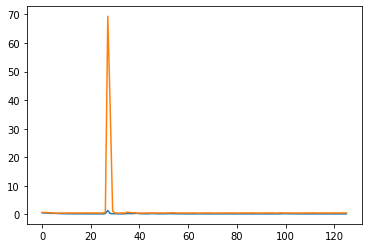

In [20]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list)
plt.plot(val_loss_list)

/tmp/ipykernel_8127/3183670863.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x) / 255
/tmp/ipykernel_8127/3183670863.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).float()
/tmp/ipykernel_8127/3183670863.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x) / 255
/tmp/ipykernel_8127/3183670863.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.

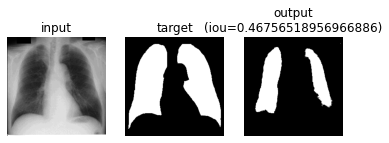

In [27]:
# DICE係数とIOUについて説明，実装
# 質的評価のための可視化方法
from sklearn.metrics import confusion_matrix

def thresholding(inference,  threshold=0.5):
    # 入力は2チャンネルのVariable
    inference = inference.data.cpu() # 最後の一枚の１チャンネル目

    mask1 = inference >= threshold
    inference[mask1] = 255

    mask0 = inference < threshold
    inference[mask0] = 0
    
    return inference

def calc_all(tp, pp):
    mask = pp != 0
    pp[mask] = 1
    tn, fp, fn, tp = confusion_matrix(tp.flatten(), pp.flatten()).ravel()
    presicion = tp / (tp + fp)
    recall = tp / (tp + fn)
    dice = tp / (tp + ((1/2)*(fp+fn)))
    iou = tp / (tp + fp + fn)
    return presicion, recall, dice, iou

test_size = len(chest_test)

iou_list = []
precision_list = []
recall_list = []
dice_list = []
test_loss_add = 0

batch_size = 5

num = 0

model = UNet(input_channel=1, output_channel=1)
model = model.to("cuda")
model_path = '/takaya_workspace/self_study/deep_learning/segmentation/models/best.model'
model.load_state_dict(torch.load(model_path))
model.eval()

precision_list = []
recall_list = []
dice_list = []
iou_list = []

for i,data in enumerate(test_loader):
    x, t = data
    x = torch.tensor(x) / 255
    t = torch.tensor(t).float()
    
    x = x.to("cuda")
    t = t.to("cuda")
        
    predict = model(x)
    predict_imgs = thresholding(predict, threshold=0.5)
    
    for j in range(batch_size):
        img = np.array(predict_imgs[j][0])
        xx = np.array(x[j][0].cpu())
        tt = np.array(t[j][0].cpu())
        
        precision, recall, dice, iou = calc_all(img/255, tt)
        precision_list.append(precision)
        recall_list.append(recall)
        dice_list.append(dice)
        iou_list.append(iou)
    
        plt.subplot(1, 3, 1)#1桁目 -- グラフの行数、2桁目 -- グラフの列数、3桁目 -- グラフの番号、subplot(2,3,1)の記載でも良い。
        plt.axis("off")
        plt.title("input")
        plt.imshow(xx, cmap = "gray")
        plt.subplot(1, 3, 2)
        plt.axis("off")
        plt.title("target")
        plt.imshow(tt, cmap = "gray")
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.title("output\n(iou=" + str(iou) + ")")
        plt.imshow(img, cmap = "gray")
        plt.savefig("/takaya_workspace/self_study/deep_learning/segmentation/results/" + str(i) + "_" + str(j) + ".png")

precision_list = np.array(precision_list)
recall_list = np.array(recall_list)
recall_list = np.nan_to_num(recall_list)
dice_list = np.array(dice_list)
iou_list = np.array(iou_list)

In [27]:
label_list = glob.glob("/takaya_workspace/self_study/deep_learning/segmentation/data/train/label/*")
for i in range(len(label_list)):
    label = Image.open(label_list[i])
    label = np.array(label) / 255
    print(label.sum())

20862.0
17155.0
14825.0
13175.0
18577.0
24999.0
22108.0
16084.0
18535.0
17977.0
23153.0
24524.0
22361.0
15265.0
19724.0
23169.0
25627.0
19298.0
19090.0
16348.0
20433.0
29502.0
19148.0
19397.0
20325.0
21373.0
21558.0
16999.0
18802.0
20906.0
16925.0
19799.0
13711.0
18784.0
20239.0
19283.0
18421.0
19968.0
16340.0
18576.0


In [32]:
predict[0].shape

torch.Size([1, 256, 256])

In [6]:
a = a.reshape((5,1))

In [7]:
a + 1

tensor([[2.],
        [3.],
        [4.],
        [5.],
        [6.]])